# Install library

In [1]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.0/449.0 KB 28.9 MB/s eta 0:00:00


In [2]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 KB 34.0 MB/s eta 0:00:00


In [3]:
!pip install PyICU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for PyICU: filename=PyICU-2.9-cp37-cp37m-linux_x86_64.whl size=1886007 sha256=32237e0d5e9805301e8a6f2062c3d9f76dd16e5b85ce9733290953ed89f15875
  Stored in directory: /root/.cache/pip/wheels/28/88/93/6c1b06361e4cbd4e7f793fb456729f69798f9aa3fc2a791cd7
Successfully built PyICU


# Library

In [4]:
import numpy as np
import pandas as pd
import string

from konlpy.tag import Okt
from underthesea import word_tokenize

import icu
import itertools

import tensorflow as tf
import torch

from sklearn.utils import shuffle

import re

In [5]:
pd.set_option('display.max_colwidth', None)

# Data

In [6]:
df = pd.read_csv('../input/112k-korean-to-vietnamese-dataset/kr-vn-112k.csv').drop_duplicates()
df

,kr,vn
0,나는 매일 저녁 배트를 만나러 다락방으로 가요,tối nào tôi cũng đến gác mái để gặp bat
1,선생님 이문장이 이해가 안 가요,tôi không hiểu câu này của thầy
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요,thời gian trôi qua quá nhanh khi tôi bắt đầu sử dụng máy tính
3,나는 오늘 자정에 한국으로 돌아 가요,nửa đêm hôm nay tôi sẽ trở về hàn quốc
4,지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요,bây giờ mà ngủ chắc không thức dậy nổi đâu nên giờ mình đi đây
...,...,...
112836,해외 사이트에서 항공권을 예약했는데 변경해야 할 것 같아,tôi đã đặt vé máy bay ở trang web nước ngoài nhưng có lẽ phải thay đổi
112850,다음 달 주말인데 그러면 혹시 주위에 아는 사람 없느냐,tháng sau cuối tuần vậy thì nếu mà xung quanh không có ai biết
112851,잘은 기억 안 나지만 내 동생이 가고 싶어 한 것 같기도 한데,tôi không nhớ rõ lắm nhưng hình như em tôi muốn đi
112854,지금 바로 쓸 테니 펜하고 양식 한 장만 부탁해요,bây giờ viết được ngay sẽ viết với mẫu một tấm


# Add token

In [7]:
df['vn'] = df['vn'].apply(lambda x: 'startseq '+ x + ' endseq')
df.head()

,kr,vn
0,나는 매일 저녁 배트를 만나러 다락방으로 가요,startseq tối nào tôi cũng đến gác mái để gặp bat endseq
1,선생님 이문장이 이해가 안 가요,startseq tôi không hiểu câu này của thầy endseq
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요,startseq thời gian trôi qua quá nhanh khi tôi bắt đầu sử dụng máy tính endseq
3,나는 오늘 자정에 한국으로 돌아 가요,startseq nửa đêm hôm nay tôi sẽ trở về hàn quốc endseq
4,지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요,startseq bây giờ mà ngủ chắc không thức dậy nổi đâu nên giờ mình đi đây endseq


# Tokenizer

In [8]:
okt=Okt()

kr_tokenizer = [] # Chứa các câu kr đã được tách từ

for i in df['kr']:
    kr_tokenizer.append(okt.morphs(i))

In [9]:
vn_tokenizer = [] # Chứa các câu vn đã được tách từ

for i in df['vn']:
    vn_tokenizer.append(word_tokenize(i))

# Create dictionary

In [10]:
def create_dictionary(data):
    dic = {}
    inx ={}
    collator = icu.Collator.createInstance(icu.Locale('de_DE.UTF-8'))
    data = list(itertools.chain.from_iterable(data))
    vals = sorted(set(data), key=collator.getSortKey)
    
    for val, key in enumerate(vals):
        dic[key] = val
        inx[val] = key
    
    return dic, inx

In [11]:
dictionary_vn, inx_dictionary_vn = create_dictionary(vn_tokenizer)

In [12]:
dictionary_kr, inx_dictionary_kr = create_dictionary(kr_tokenizer)

# Padding

In [13]:
def generate_sample(data, dic):
    context_word = []
    for seq in data:
        wordset = seq
        context_word.append([dic[j] for j in wordset])
    return context_word

In [14]:
in_seq = generate_sample(kr_tokenizer, dictionary_kr)
in_seq[:2]

[[5180, 7240, 13006, 31107, 15930, 11606, 12095, 7613, 28339, 630],
 [20279, 28770, 30871, 29080, 107, 23759, 630]]

In [15]:
out_seq = generate_sample(vn_tokenizer, dictionary_vn)
out_seq[:2]

[[10578, 11986, 7838, 11985, 2612, 3174, 4146, 7089, 3121, 4216, 672, 3957],
 [10578, 11985, 6157, 5030, 1591, 7875, 2574, 11272, 3957]]

In [16]:
maxlenght_input = len(max(in_seq, key=len))
in_seq_pad = torch.tensor(tf.keras.preprocessing.sequence.pad_sequences(in_seq, maxlenght_input, padding='post'))

In [17]:
print(maxlenght_input)
in_seq_pad[:2]

32


tensor([[ 5180,  7240, 13006, 31107, 15930, 11606, 12095,  7613, 28339,   630,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [20279, 28770, 30871, 29080,   107, 23759,   630,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]], dtype=torch.int32)

In [18]:
maxlenght_output = len(max(out_seq, key = len))
out_seq_pad = torch.tensor(tf.keras.preprocessing.sequence.pad_sequences(out_seq, maxlenght_output, padding='post'))

In [19]:
print(maxlenght_output)
out_seq_pad[:2]

40


tensor([[10578, 11986,  7838, 11985,  2612,  3174,  4146,  7089,  3121,  4216,
           672,  3957,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [10578, 11985,  6157,  5030,  1591,  7875,  2574, 11272,  3957,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=torch.int32)

# Split data

In [20]:
df = shuffle(df, random_state=42)

In [21]:
from sklearn.model_selection import train_test_split

text_pairs = [(i, j) for i, j in zip(df['kr'], df['vn'])]

num_val_samples = int(0.12 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f'{len(text_pairs)} total pairs')
print(f'{len(train_pairs)} training pairs')
print(f'{len(val_pairs)} validation pairs')
print(f'{len(test_pairs)} test pairs')

99670 total pairs
75750 training pairs
11960 validation pairs
11960 test pairs


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

sequence_length = maxlenght_input
batch_size = 64

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


kr_vectorization = TextVectorization(
    max_tokens=len(dictionary_kr), output_mode="int", output_sequence_length=maxlenght_input,
)
vn_vectorization = TextVectorization(
    max_tokens=len(dictionary_vn),
    output_mode="int",
    output_sequence_length=maxlenght_input + 1,
    standardize=custom_standardization,
)
train_kr_texts = [pair[0] for pair in train_pairs]
train_vn_texts = [pair[1] for pair in train_pairs]
kr_vectorization.adapt(train_kr_texts)
vn_vectorization.adapt(train_vn_texts)

2022-05-15 16:54:34.410979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:54:34.412176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:54:34.412924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:54:34.415176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
def format_dataset(kr, vn):
    kr = kr_vectorization(kr)
    vn = vn_vectorization(vn)
    return ({"encoder_inputs": kr, "decoder_inputs": vn[:, :-1],}, vn[:, 1:])


def make_dataset(pairs):
    kr_texts, vn_texts = zip(*pairs)
    kr_texts = list(kr_texts)
    vn_texts = list(vn_texts)
    dataset = tf.data.Dataset.from_tensor_slices((kr_texts, vn_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [24]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 32)
inputs["decoder_inputs"].shape: (64, 32)
targets.shape: (64, 32)


2022-05-15 16:54:56.877182: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Model building

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [28]:
embed_dim = 256
latent_dim = 2048
num_heads = 8
vocab_size_in = len(dictionary_kr)
vocab_size_out = len(dictionary_vn)
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(maxlenght_input, vocab_size_in, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(maxlenght_input, vocab_size_out, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size_out, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [29]:
transformer = keras.Model([encoder_inputs, decoder_inputs], 
                          decoder_outputs, 
                          name="transformer")
transformer.summary()
transformer.compile("rmsprop", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    10613504    encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

In [30]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./modelcheckpoint.hdf5",
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

In [31]:
epochs = 100

history = transformer.fit(train_ds, 
                     epochs=epochs, 
                     validation_data=val_ds, 
                     callbacks=[model_checkpoint])

# history = transformer.fit(train_ds, 
#                      epochs=epochs, 
#                      validation_data=val_ds)

Epoch 1/100


2022-05-15 16:55:11.401665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1184/1184 [==============================] - 119s 91ms/step - loss: 1.8669 - accuracy: 0.3280 - val_loss: 1.5403 - val_accuracy: 0.4037
Epoch 2/100
1184/1184 [==============================] - 107s 90ms/step - loss: 1.5489 - accuracy: 0.4237 - val_loss: 1.4644 - val_accuracy: 0.4433
Epoch 3/100
1184/1184 [==============================] - 107s 90ms/step - loss: 1.4017 - accuracy: 0.4717 - val_loss: 1.3210 - val_accuracy: 0.4826
Epoch 4/100
1184/1184 [==============================] - 107s 90ms/step - loss: 1.2821 - accuracy: 0.5094 - val_loss: 1.2730 - val_accuracy: 0.4984
Epoch 5/100
1184/1184 [==============================] - 106s 90ms/step - loss: 1.1821 - accuracy: 0.5407 - val_loss: 1.2440 - val_accuracy: 0.5111
Epoch 6/100
1184/1184 [==============================] - 107s 90ms/step - loss: 1.1026 - accuracy: 0.5683 - val_loss: 1.2353 - val_accuracy: 0.5184
Epoch 7/100
1184/1184 [==============================] - 107s 90ms/step - loss: 1.0440 - accuracy: 0.5916 - val_loss: 1.2365

In [32]:
# # Load checkpoint

# transformer = keras.Model([encoder_inputs, decoder_inputs], 
#                           decoder_outputs, 
#                           name="transformer")
# transformer.summary()
# transformer.compile("rmsprop", 
#                     loss="sparse_categorical_crossentropy", 
#                     metrics=["accuracy"])

# transformer.load_weights('../input/pretrainkrvn/checkpoint.hdf5')

# loss, acc = transformer.evaluate(val_ds, verbose=2)
# print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [33]:
vn_vocab = vn_vectorization.get_vocabulary()
vn_index_lookup = dict(zip(range(len(vn_vocab)), vn_vocab))
max_decoded_sentence_length = maxlenght_output


def decode_sequence(input_sentence):
    tokenized_input_sentence = kr_vectorization([input_sentence])
    decoded_sentence = "startseq"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vn_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = vn_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "endseq":
            break
    return decoded_sentence

# Model Evaluation

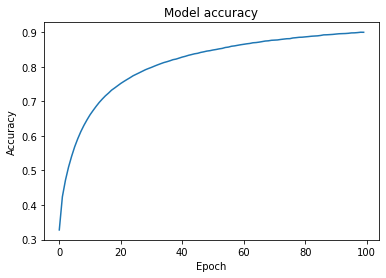

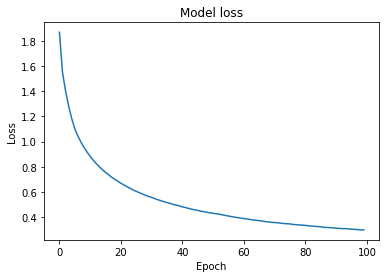

In [34]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# BLEU

In [35]:
data_test = train_pairs[:7000] + test_pairs[:3000] 

In [36]:
from nltk.translate.bleu_score import sentence_bleu

In [37]:
scores_bleu = 0
count_bleu = 0

for i in data_test:
    try:
        predict = decode_sequence(i[0])
        score = sentence_bleu(i[1], predict)
        scores_bleu += score
        count_bleu += 1
#         print('kr: ', i[0])
#         print('actual: ', i[1])
#         print('predicted: ', predict)
#         print(score)
        print(count_bleu, end='-')
    except:
        continue

print('\n\nCount_bleu: ', count_bleu)
print('AVERAGE BLEU SCORE: ', scores_bleu/count_bleu)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-256-257-258-259-260-261-262-263-264-265-266-267-268-269-270-271-272-273-274-275-276-277-

2022-05-15 20:45:15.391406: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: slice index 32 of dimension 1 out of bounds.


987-988-989-990-991-992-993-994-995-996-997-998-999-1000-1001-1002-1003-1004-1005-1006-1007-1008-1009-1010-1011-1012-1013-1014-1015-1016-1017-1018-1019-1020-1021-1022-1023-1024-1025-1026-1027-1028-1029-1030-1031-1032-1033-1034-1035-1036-1037-1038-1039-1040-1041-1042-1043-1044-1045-1046-1047-1048-1049-1050-1051-1052-1053-1054-1055-1056-1057-1058-1059-1060-1061-1062-1063-1064-1065-1066-1067-1068-1069-1070-1071-1072-1073-1074-1075-1076-1077-1078-1079-1080-1081-1082-1083-1084-1085-1086-1087-1088-1089-1090-1091-1092-1093-1094-1095-1096-1097-1098-1099-1100-1101-1102-1103-1104-1105-1106-1107-1108-1109-1110-1111-1112-1113-1114-1115-1116-1117-1118-1119-1120-1121-1122-1123-1124-1125-1126-1127-1128-1129-1130-1131-1132-1133-1134-1135-1136-1137-1138-1139-1140-1141-1142-1143-1144-1145-1146-1147-1148-1149-1150-1151-1152-1153-1154-1155-1156-1157-1158-1159-1160-1161-1162-1163-1164-1165-1166-1167-1168-1169-1170-1171-1172-1173-1174-1175-1176-1177-1178-1179-1180-1181-1182-1183-1184-1185-1186-1187-1188-118

2022-05-15 21:23:14.419192: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: slice index 32 of dimension 1 out of bounds.


6065-6066-6067-6068-6069-6070-6071-6072-6073-6074-6075-6076-6077-6078-6079-6080-6081-6082-6083-6084-6085-6086-6087-6088-6089-6090-6091-6092-6093-6094-6095-6096-6097-6098-6099-6100-6101-6102-6103-6104-6105-6106-6107-6108-6109-6110-6111-6112-6113-6114-6115-6116-6117-6118-6119-6120-6121-6122-6123-6124-6125-6126-6127-6128-6129-6130-6131-6132-6133-6134-6135-6136-6137-6138-6139-6140-6141-6142-6143-6144-6145-6146-6147-6148-6149-6150-6151-6152-6153-6154-6155-6156-6157-6158-6159-6160-6161-6162-6163-6164-6165-6166-6167-6168-6169-6170-6171-6172-6173-6174-6175-6176-6177-6178-6179-6180-6181-6182-6183-6184-6185-6186-6187-6188-6189-6190-6191-6192-6193-6194-6195-6196-6197-6198-6199-6200-6201-6202-6203-6204-6205-6206-6207-6208-6209-6210-6211-6212-6213-6214-6215-6216-6217-6218-6219-6220-6221-6222-6223-6224-6225-6226-6227-6228-6229-6230-6231-6232-6233-6234-6235-6236-6237-6238-6239-6240-6241-6242-6243-6244-6245-6246-6247-6248-6249-6250-6251-6252-6253-6254-6255-6256-6257-6258-6259-6260-6261-6262-6263-6264-

2022-05-15 21:32:26.614547: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: slice index 32 of dimension 1 out of bounds.


7296-7297-7298-7299-7300-7301-7302-7303-7304-7305-7306-7307-7308-7309-7310-7311-7312-7313-7314-7315-7316-7317-7318-7319-7320-7321-7322-7323-7324-7325-7326-7327-7328-7329-7330-7331-7332-7333-7334-7335-7336-7337-7338-7339-7340-7341-7342-7343-7344-7345-7346-7347-7348-7349-7350-7351-7352-7353-7354-7355-7356-7357-7358-7359-7360-7361-7362-7363-7364-7365-7366-7367-7368-7369-7370-7371-7372-7373-7374-7375-7376-7377-7378-7379-7380-7381-7382-7383-7384-7385-7386-7387-7388-7389-7390-7391-7392-7393-7394-7395-7396-7397-7398-7399-7400-7401-7402-7403-7404-7405-7406-7407-7408-7409-7410-7411-7412-7413-7414-7415-7416-7417-7418-7419-7420-7421-7422-7423-7424-7425-7426-7427-7428-7429-7430-7431-7432-7433-7434-7435-7436-7437-7438-7439-7440-7441-7442-7443-7444-7445-7446-7447-7448-7449-7450-7451-7452-7453-7454-7455-7456-7457-7458-7459-7460-7461-7462-7463-7464-7465-7466-7467-7468-7469-7470-7471-7472-7473-7474-7475-7476-7477-7478-7479-7480-7481-7482-7483-7484-7485-7486-7487-7488-7489-7490-7491-7492-7493-7494-7495-

# Predict

In [38]:
test_kr_texts = [pair for pair in data_test]


for _ in range(5):
    input_sentence = random.choice(test_kr_texts)
#     input_sentence = "start cam on vi da den"
    translated = decode_sequence(input_sentence[0])
    print('kr: ', input_sentence[0])
    print('actual: ', input_sentence[1])
    print('predict: ', translated)
    print('\n------------------------------------------------------------------------\n')

kr:  일요일 오후에 약속 잡아 놓겠어요
actual:  startseq tôi sẽ hẹn vào chiều chủ nhật endseq
predict:  startseq tôi sẽ hẹn vào chiều chủ nhật endseq

------------------------------------------------------------------------

kr:  여기에는 기도실이 없고 옆에 이태원에 가야 있습니다
actual:  startseq ở đây không có phòng cầu nguyện bên cạnh là itaewon endseq
predict:  startseq ở đây không có phòng cầu nguyện bên cạnh là có phòng phải đi đến không có endseq

------------------------------------------------------------------------

kr:  사람은 나이를 먹는 것이 아니라 좋은 포도주처럼 익는 것이에요
actual:  startseq con người không phải già đi mà là chín như rượu nho ngon endseq
predict:  startseq con người không phải già đi mà là có cổ vũ không nhưng tàu điện ngầm endseq

------------------------------------------------------------------------

kr:  글쎄 남동생이 내 숙제를 다 지워 버린 것이에요
actual:  startseq xem nào em trai tôi đã xóa hết bài tập của tôi endseq
predict:  startseq xem nào em trai tôi đã chạm vào bài tập của tôi endseq

---------------------------------